In [1]:
import image_functions as utils
from skimage.segmentation import watershed
from skimage.color import label2rgb
from skimage.morphology import (
    disk,
    opening,
    closing,
    reconstruction,
    erosion,
    dilation,
    remove_small_objects,
)
from scipy.ndimage import maximum_filter, distance_transform_edt
import numpy as np
from skimage.measure import label
from skimage.filters import threshold_otsu, sobel
import matplotlib.pyplot as plt
import cv2
import pytesseract

ModuleNotFoundError: No module named 'image_functions'

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/sujith/Environments/IVP_env/lib/python3.11/site-packages/cv2/qt/plugins"


Car detected at speed breaker!


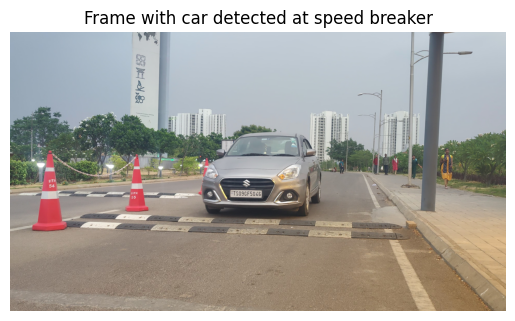

In [ ]:
cap = cv2.VideoCapture("examples/2.mp4")  #Example Videos

# Define the ROI coordinates (x, y, width, height)
# These should be adjusted based on where the speed breaker is in your video
roi_x, roi_y, roi_w, roi_h = 1175, 1275, 1300, 250  # Example values

car_detected = False
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale and blur it
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Define ROI and detect edges
    roi = gray_blur[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]
    edges = cv2.Canny(roi, 100, 200)

    # Check for significant changes in the ROI
    nonzero_count = np.count_nonzero(edges)

    if nonzero_count > 8000 and not car_detected:  # Threshold to tweak based on your scenario
        frame_count += 1
        car_detected = True
        print("Car detected at speed breaker!")
        cv2.imwrite(f"car{frame_count}.jpg", frame)  # Save the frame as JPEG file
        # cv2.imshow('frame selected',frame)

    
    # Reset detection state if no edges are detected
    if nonzero_count < 2000 and car_detected:
        car_detected = False

    cv2.imshow('Edges in ROI', edges)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

saved_frame = cv2.imread(f"car1.jpg")
saved_frame_rgb = cv2.cvtColor(saved_frame, cv2.COLOR_BGR2RGB)
plt.imshow(saved_frame_rgb, cmap='gray')
plt.axis('off')
plt.title('Frame with car detected at speed breaker')
plt.show()


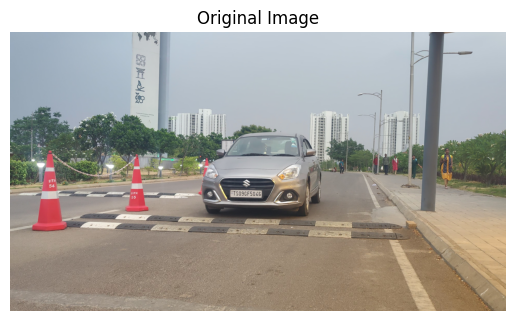

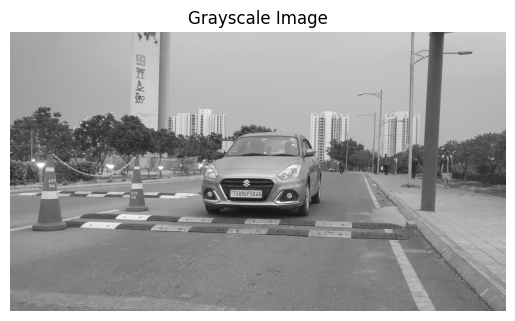

In [ ]:
# Read the original image
image = utils.read_image("car1.jpg")

# Display the original image
utils.display_image(image, "Original Image")

# Convert the original image to grayscale
grayscale_image = utils.convert_grayscale(image)
grayscale_image = grayscale_image / grayscale_image.max()

# Display the grayscale image
utils.display_image(grayscale_image, "Grayscale Image")

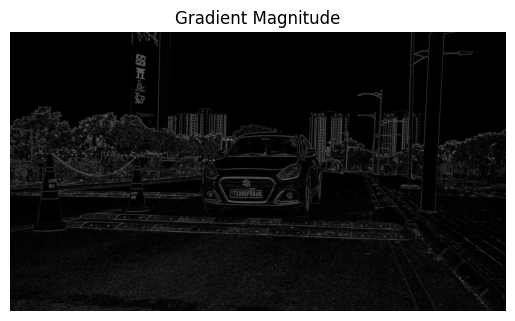

In [ ]:
gradient_magnitude = utils.imgradient(grayscale_image)

# Display the gradient magnitude
utils.display_image(gradient_magnitude, "Gradient Magnitude")

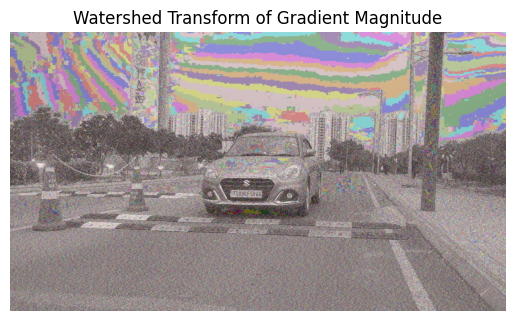

In [ ]:
# Apply watershed transform
segmented_image = watershed(gradient_magnitude)

# Convert segmented image to RGB for visualization
segmented_rgb = label2rgb(segmented_image, image=grayscale_image)

# Display the segmented image
utils.display_image(segmented_rgb, "Watershed Transform of Gradient Magnitude")

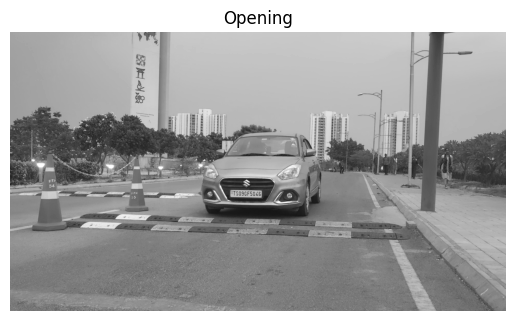

In [ ]:
structuring_element = disk(2)

image_opened = opening(grayscale_image, structuring_element)

# Display the opened image
utils.display_image(image_opened, 'Opening')

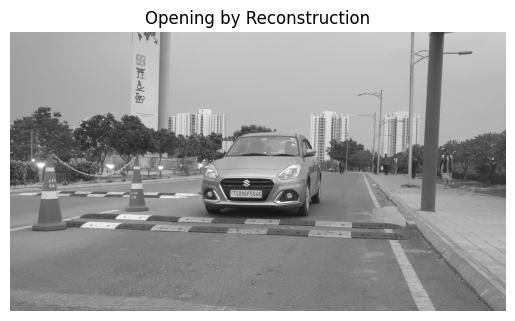

In [ ]:
image_eroded = erosion(grayscale_image, structuring_element)

image_open_by_reconstruction = reconstruction(image_eroded, grayscale_image)

# Display the opened by reconstruction image
utils.display_image(image_open_by_reconstruction, 'Opening by Reconstruction')

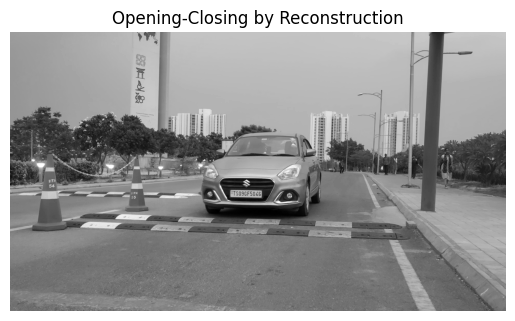

In [ ]:
# Perform Dilation
image_dilated = dilation(image_open_by_reconstruction, structuring_element)

# Perform Reconstruction
image_reconstructed = reconstruction(1 - image_dilated, 1 - image_open_by_reconstruction)
image_reconstructed = 1 - image_reconstructed

# Display the reconstructed image
utils.display_image(image_reconstructed, 'Opening-Closing by Reconstruction')

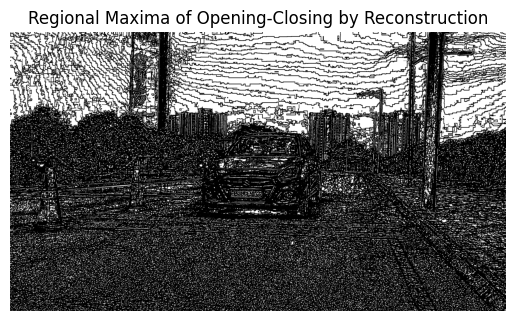

In [ ]:
# Apply Maximum Filter
local_max = maximum_filter(image_reconstructed, footprint=np.ones((10,10)))

# Find Regional Maxima
foreground_markers = (image_reconstructed == local_max)

# Display the regional maxima
utils.display_image(foreground_markers, 'Regional Maxima of Opening-Closing by Reconstruction' )

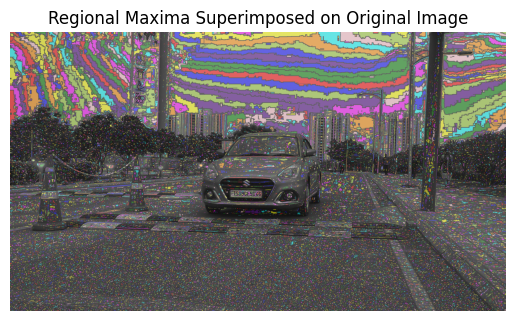

In [ ]:
# Labelled the regional maxima
labelled_foreground_markers = label(foreground_markers)

# Superimpose regional maxima on the original image
markers_rgb = label2rgb(labelled_foreground_markers, image=grayscale_image, bg_label=0, alpha=0.5)

# Display the regional maxima superimposed on the original image
utils.display_image(markers_rgb, 'Regional Maxima Superimposed on Original Image')

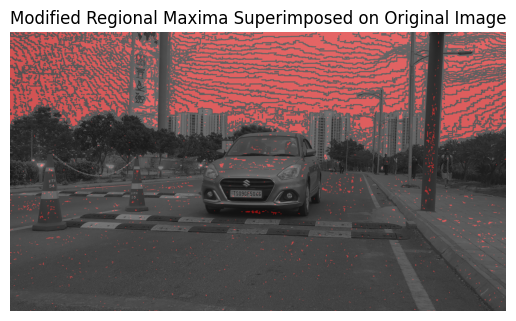

In [ ]:
# Define structuring element
structuring_element_new = np.ones((5,5))

# perform closing operation on regional maxima
markers_closed = closing(foreground_markers, structuring_element_new)

# perform erosion operation on regional maxima
markers_eroded = erosion(markers_closed, structuring_element_new)

# remove small objects
markers_cleaned = remove_small_objects(markers_eroded, min_size=20)

# Superimpose modified regional maxima on the original image
markers_cleaned_rgb = label2rgb(markers_cleaned, image=grayscale_image, bg_label=0, alpha=0.5)

# Display the modified regional maxima superimposed on the original image
utils.display_image(markers_cleaned_rgb, 'Modified Regional Maxima Superimposed on Original Image')


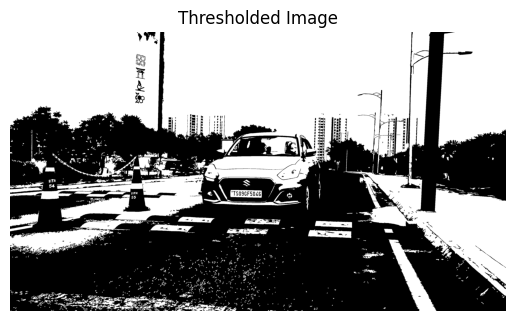

In [ ]:
# Compute Otsu's threshold
threshold = threshold_otsu(image_reconstructed)

# Perform thresholding
thresholded_image = image_reconstructed > threshold

# Display the thresholded image
utils.display_image(thresholded_image, 'Thresholded Image')

In [ ]:
# Compute Euclidean distance transform
distance_transform = distance_transform_edt(thresholded_image)

# Perform watershed segmentation
segmented_image = watershed(distance_transform)

# Identify background markers
background_markers = (segmented_image == 0)

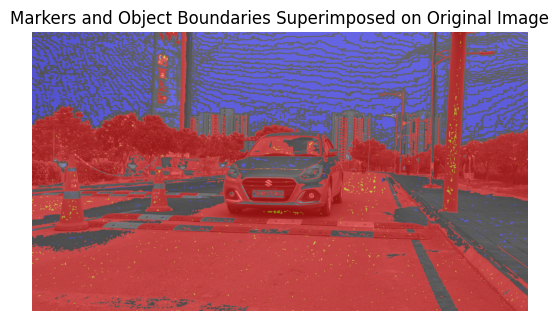

In [ ]:
# Imposemin operation
gradient_magnitude_new = utils.imposemin(gradient_magnitude, np.logical_or(background_markers, markers_cleaned))

# Watershed segmentation
segmented_image = watershed(gradient_magnitude_new, markers=utils.estimate_markers(gradient_magnitude_new), mask=thresholded_image)

# Create labels for visualization
labels = dilation(segmented_image==0, np.ones((3,3))) + 2*background_markers + 3*markers_cleaned

# Superimpose markers and object boundaries on the original image
segmented_rgb = label2rgb(labels, image=grayscale_image, bg_label=0, alpha=0.5)

# Display the final segmented image
utils.display_image(segmented_rgb, 'Markers and Object Boundaries Superimposed on Original Image')

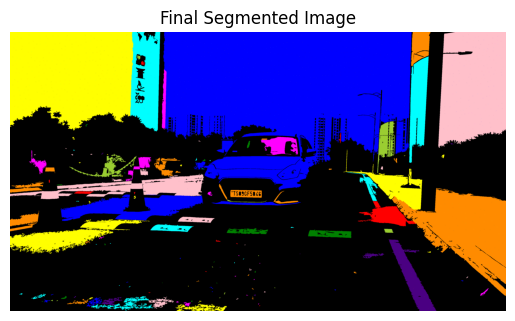

In [ ]:
# Convert labels to RGB
segmented_rgb_final = label2rgb(segmented_image, image=segmented_rgb, bg_label=0, alpha=1)

# Display the final segmented image
utils.display_image(segmented_rgb_final, 'Final Segmented Image')

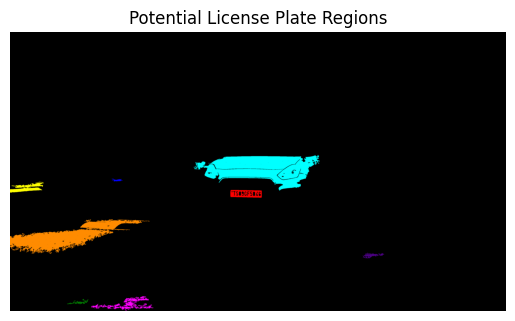

In [ ]:
# Select potential license plate regions
regions = utils.select_license_plate_regions(segmented_image)

# Convert labeled regions to RGB for visualization
regions_rgb = label2rgb(regions, image=grayscale_image, bg_label=0, alpha=1)

utils.display_image(regions_rgb, 'Potential License Plate Regions')

In [ ]:
x = regions_rgb.reshape(-1, 3)

# Find unique colors
unique_colors = np.unique(x, axis=0)

# Exclude white color
white_color = np.array([255, 255, 255])
unique_colors = unique_colors[~np.all(unique_colors == white_color, axis=1)]
unique_colors = np.array(unique_colors)

# Count unique colors
unique_colors_count = len(unique_colors)

print(unique_colors_count)

9


In [ ]:
coordsList = []

# Iterate over each unique color
for selected_color in unique_colors:
    # Create a mask for the selected color
    segment = np.all(regions_rgb == selected_color, axis=-1)

    # Apply the mask to the image to isolate the selected color
    isolated_color = np.zeros_like(regions_rgb)
    isolated_color[segment] = selected_color

    # Compute MER coordinates for the isolated color
    coords = utils.compute_mer(isolated_color, selected_color)

    # Append the coordinates to the list
    coordsList.append(coords)

In [ ]:
n = len(coordsList)

acceptedImagesIndex = []
acceptedCoordsList = []

for i in range(n):
    tl, tr, bl, br = coordsList[i]

    # Calculate width and height of the MER
    width = np.linalg.norm(tl - tr)
    height = np.linalg.norm(tl - bl)

    # Calculate aspect ratio
    aspect_ratio = width / height

    print("Aspect Ratio:", aspect_ratio)

    # Check if aspect ratio falls within the specified range
    if 2 <= aspect_ratio <= 5:
        acceptedImagesIndex.append(i)
        acceptedCoordsList.append(coordsList[i])

# Print accepted indices and corresponding coordinates
print("Accepted Images Index:", acceptedImagesIndex)
print("Accepted Coordinates List:", acceptedCoordsList)


Aspect Ratio: 1.778138026864289
Aspect Ratio: 3.9523809523809526
Aspect Ratio: 4.256410256410256
Aspect Ratio: 3.512635379061372
Aspect Ratio: 3.883720930232558
Aspect Ratio: 4.101694915254237
Aspect Ratio: 4.342342342342342
Aspect Ratio: 4.056390977443609
Aspect Ratio: 3.1463414634146343
Accepted Images Index: [1, 2, 3, 4, 5, 6, 7, 8]
Accepted Coordinates List: [(array([ 787, 1135]), array([ 870, 1135]), array([ 787, 1156]), array([ 870, 1156])), (array([ 441, 2067]), array([ 607, 2067]), array([ 441, 2106]), array([ 607, 2106])), (array([1421,  950]), array([2394,  950]), array([1421, 1227]), array([2394, 1227])), (array([2730, 1709]), array([2897, 1709]), array([2730, 1752]), array([2897, 1752])), (array([1706, 1223]), array([1948, 1223]), array([1706, 1282]), array([1948, 1282])), (array([ 627, 2045]), array([1109, 2045]), array([ 627, 2156]), array([1109, 2156])), (array([   0, 1450]), array([1079, 1450]), array([   0, 1716]), array([1079, 1716])), (array([   0, 1160]), array([ 25

In [ ]:
# Display the potential license plate regions


In [ ]:
print("Shape of regions_rgb:", regions_rgb.shape)

# Create an empty list to store masks
Mask = []

# Iterate over accepted image indices
for i in acceptedImagesIndex:
    # Get the selected color
    selected_color = unique_colors[i]

    # Create a mask for the selected color
    segment = np.all(regions_rgb == selected_color, axis=-1)

    # Convert the 2D mask to 3D by repeating it along the third axis
    mask_3d = segment[:, :, np.newaxis]
    mask_3d = np.repeat(mask_3d, 3, axis=2)

    # Append the mask to the list
    Mask.append(mask_3d)

Shape of regions_rgb: (2160, 3840, 3)


In [ ]:
filteredSegments = []

# Iterate over each mask
for mask_3d in Mask:
    # Apply the mask to the original image
    masked_segment = mask_3d * image
    # Append the masked segment to filteredSegments
    filteredSegments.append(masked_segment)

In [ ]:
n = len(filteredSegments)
boundedSegments = []

# Iterate over each filtered segment
for i in range(n):
    # Retrieve MER coordinates
    tl, tr, bl, br = acceptedCoordsList[i]

    # Extract x and y coordinates of the bounding box
    xMin, yMin = tl
    xMax, yMin = tr
    xMin, yMax = bl
    xMax, yMax = br

    # Extract the bounded segment using slicing
    boundedSegment = filteredSegments[i][yMin:yMax, xMin:xMax]

    # Append the bounded segment to the list
    boundedSegments.append(boundedSegment)

In [ ]:
newAcceptedList = []
newSegments = []

n = len(acceptedCoordsList)

for i in range(n):

    tl, tr, bl, br = acceptedCoordsList[i]

    width = np.linalg.norm(tl - tr)
    height = np.linalg.norm(tl - bl)

    aspectRatio = width / height

    xMin, yMin = tl
    xMax, yMin = tr
    xMin, yMax = bl
    xMax, yMax = br

    x, y, _ = boundedSegments[i].shape
    bboxArea = x * y

    blackColor = np.array([0.0, 0.0, 0.0])

    nonzeroArea = np.sum(np.any(boundedSegments[i] != blackColor, axis=-1))

    rectangularity = nonzeroArea / bboxArea

    print(rectangularity)

    # print(aspectRatio)

    if rectangularity >= 0.4:
        newSegments.append(boundedSegments[i])
        newAcceptedList.append(acceptedCoordsList[i])

0.5169248422260471
0.2916280506641952
0.5385851195268643
0.40885670519426265
0.7248914413783443
0.24735523905648388
0.3604318953082428
0.47409718283229346


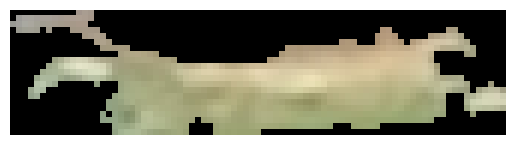

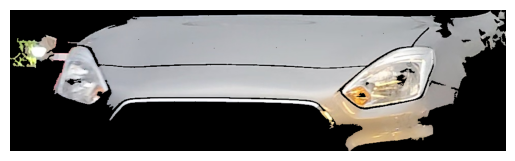

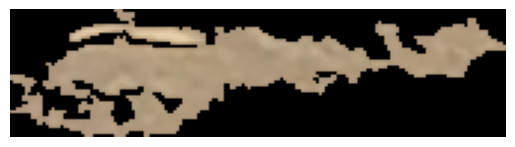

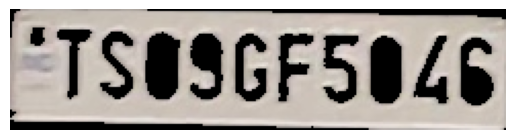

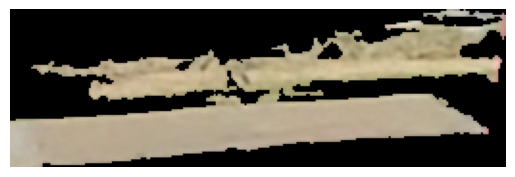

In [ ]:
for newSegment in newSegments:
    plt.imshow(newSegment)
    plt.axis('off')
    plt.show()

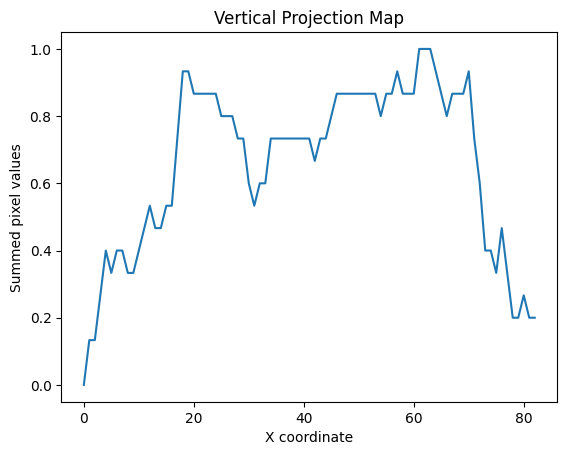

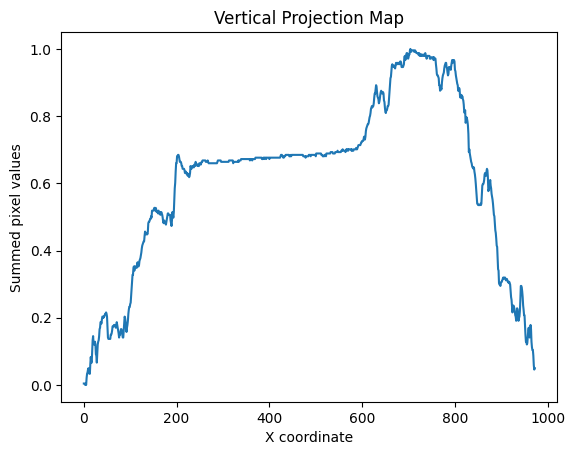

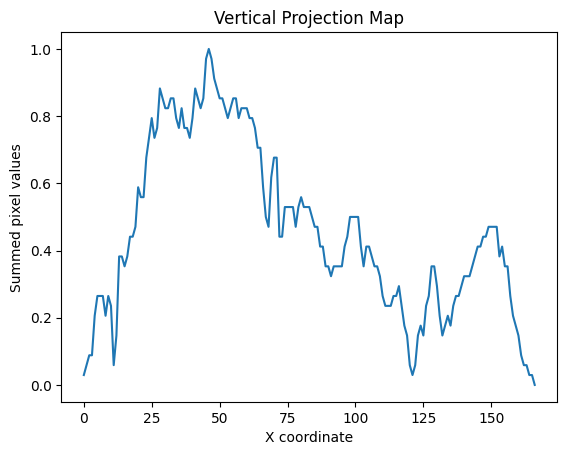

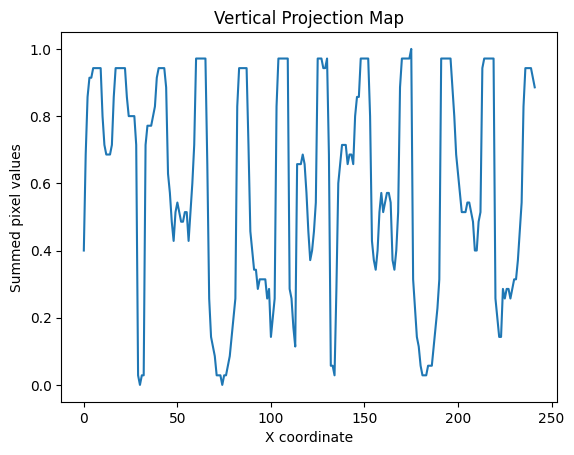

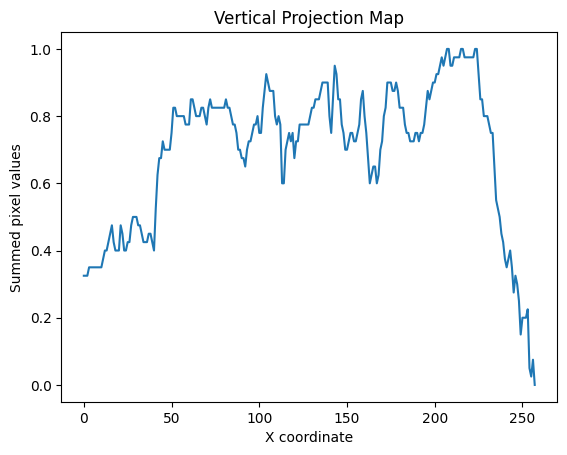

In [ ]:
vpmList = []
binary_images = []

for segment in newSegments:
    # Convert segment to uint8 if it's in float64 format
    if segment.dtype == np.float64:
        segment = ((segment - segment.min()) / (segment.max() - segment.min()) * 255).astype(np.uint8)

    # Convert to grayscale
    gray = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY)

    # Thresholding using Otsu's method
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Append the binary image to binary_images
    binary_images.append(binary_image)

    # Compute vertical Sobel gradient
    sobel_vertical = sobel(binary_image, axis=1)

    # Compute Vertical Projection Map (VPM)
    vpm = np.sum(binary_image, axis=0)
    normalized_vpm = (vpm - np.min(vpm)) / (np.max(vpm) - np.min(vpm))

    # Append the normalized VPM to vpmList
    vpmList.append(normalized_vpm)

    # Plot the normalized VPM
    plt.plot(normalized_vpm)
    plt.title('Vertical Projection Map')
    plt.xlabel('X coordinate')
    plt.ylabel('Summed pixel values')
    plt.show()


In [ ]:
len(binary_images)

5

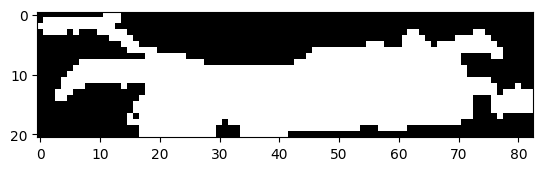

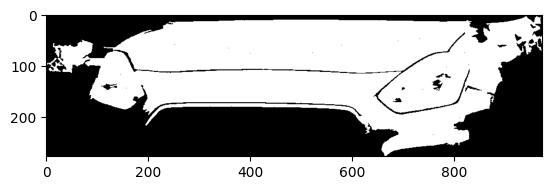

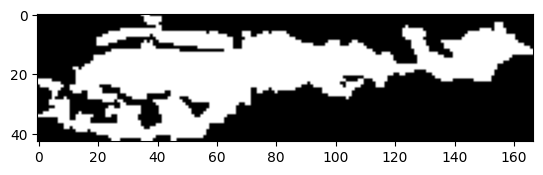

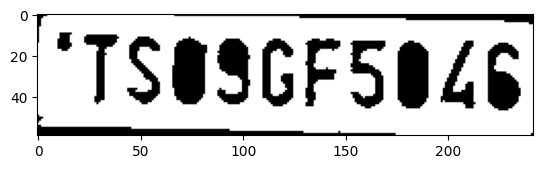

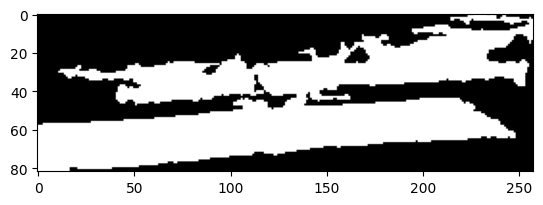

In [ ]:
for binary_image in binary_images:
    plt.imshow(binary_image, cmap='gray')
    plt.show()

In [ ]:
scoreList = []

# Iterate over each VPM in vpmList
for vpm in vpmList:
    # Calculate the score for the current VPM
    score = utils.score_license_plate(vpm)
    # Append the score to scoreList
    scoreList.append(score)
    # Print the score
    print("Score:", score)


Score: 0.49479166666666663
Score: 0.6592066983485114
Score: 0.46875
Score: 0.7704735981524886
Score: 0.7747313604171892


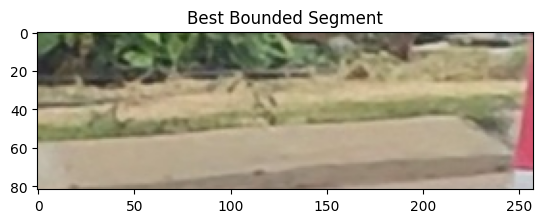

In [ ]:
# Convert scoreList to numpy array
scoreList = np.array(scoreList)

# Find the index of the best segment (highest score)
bestSegmentIndex = np.argmax(scoreList)

# Retrieve the coordinates of the best segment
bestCoords = newAcceptedList[bestSegmentIndex]

# Unpack the coordinates
tl, tr, bl, br = bestCoords
xMin, yMin = tl
xMax, _ = tr
_, yMax = bl

# Extract the bounded segment from the original image
boundedSegment = image[yMin:yMax, xMin:xMax]

# Visualize the bounded segment
plt.imshow(boundedSegment)
plt.title("Best Bounded Segment")
plt.show()


In [ ]:
# Convert the bounded segment (NumPy array) to a PIL Image
img = utils.numpy_array_to_pil(boundedSegment)

# Preprocess the image for better OCR results
preprocessed_img = utils.preprocess_image(img)

# plt.imshow(preprocessed_img, cmap='gray')

# Use PyTesseract to extract text
# '--psm 7' assumes a single text line, change if necessary based on the number plate's orientation
extracted_text = pytesseract.image_to_string(preprocessed_img, config='--psm 7')

# Extract the number plate text (assuming it's the last 10 characters)
number = extracted_text.strip()[-10:]

# Mapping of digits to letters
digit_to_letter = {'0': 'O', '1': ' T', '2': 'Z', '3': 'E', '4': 'A', '5': 'S', '6': 'G', '7': 'T', '8': 'S', '9': 'P'}


# Replace '$' with 'S' if it appears in the extracted text
number = number.replace('$', 'S')

# Convert digits to appropriate letters in positions 1, 2, 5, and 6
number = digit_to_letter.get(number[0], number[0]) + digit_to_letter.get(number[1], number[1]) + number[2] + number[3] + digit_to_letter.get(number[4], number[4]) + digit_to_letter.get(number[5], number[5]) + number[6] + number[7]+ number[8] + number[9]


# Print the last 10 characters of the recognized text
print("Last 10 characters of extracted text:", number)

Last 10 characters of extracted text: o : — - <j
